##**Dataset Information**

For this project, I use the dataset from Chowdhury et al., which contains 3886 images and indicates whether each image is COVID-19, viral pneumonia, or normal. This dataset precisely contains 1200 Covid images, 1345 viral pneumonia images, and 1341 regular images. This dataset is important because after transforming the data and resizing the images which is done in the following sections, we can build machine learning models to accurately predict which images are COVID-19 without having to use expensive equipment or involve medical practitioners to diagnose people with COVID-19. Thus, clinics and medical programs that use the traditional RT-PCR method of diagnosis can benefit from this dataset by using this as an alternative diagnosis method, as this is less costly and the information is more accessible.

After extracting the files, re-sizing the data then transforming it, one-hot encoding the categories into dummy variables, we then split the files into a training set and testing set. We then build three different versions of neural network models to predict which category each image goes into. Considering the best model was able to accurately predict approximately 96.8% of covid cases, which is 4% better than rapid covid test detection and nearly exactly the same accuracy as the PCR covid detection strategy.

## **Set up Environment**

In [ ]:
#install aimodelshare library
%%capture
! pip install aimodelshare --upgrade

In [ ]:
# Download and unpack data
%%capture
!pip install --upgrade --no-cache-dir gdown
!gdown --id '1-Ku-fu1X9pge26ZMji_yCKQqWDWbajCV' -O "COVID-19_Radiography_Database.zip"
!unzip COVID-19_Radiography_Database.zip 

In [ ]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.nn import leaky_relu


In [ ]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [1200, 1341, 1345]


## **Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor function that preprocesses data into the precise data the model requires to generate predictions.  


In [ ]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Use opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
#preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

In [ ]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [ ]:
len(image_filepaths)

3886

In [ ]:
print(len(X) ) # same number of elements as filenames
print(X.shape ) # dimensions now 192,192,3 for all images
print(X.min() ) # min value of every image is zero
print(X.max() ) # max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [ ]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


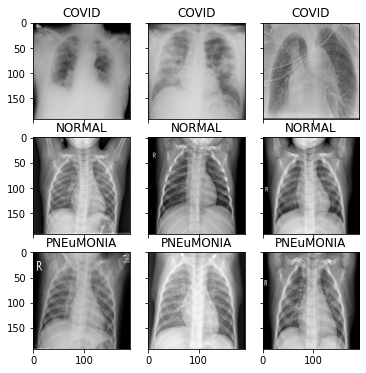

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

covim1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png')
covim2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (50).png')
covim3 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1000).png')
normalim1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
normalim2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (50).png')
normalim3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
pneim1 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')
pneim2 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (50).png')
pneim3 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1000).png')

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )
#Add labels
labels = ['COVID', 'COVID', 'COVID', "NORMAL", "NORMAL", "NORMAL", "PNEuMONIA", "PNEuMONIA", "PNEuMONIA"]
label = 0
for axes in grid:
    axes.set_title(labels[label], fontdict=None, loc='center', color = "k")
    label +=1

for ax, im in zip(grid, [covim1, covim2, covim3, normalim1, normalim2, normalim3, pneim1, pneim2, pneim3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

From the image comparison, you can tell that the x-rays depict the lungs of covid-infected persons because have lungs that look much cloudier, also known as "ground glass opacity". This is because getting infected with COVID-19 causes the density of an individual's lungs to increase. We can also tell that the lung markings become fuzzier and are almost completely unvisible due to the whiteness of the images. 

It is much more difficult to distinguish the difference between an x-ray of a normal patient with a viral pneumonia-infected patient. However, we can still tell that patients with vial-pneumonia have a slight expansion of the lungs, and also a slight cloudiness (although not nearly to the extent that covid x-rays show). 

We can tell that in both cases - viral pneumonia and normal x-rays -, they are very different from x-rays of patients with covid because they are less "white", more transparent, and you can see all or almost all of the lung markings.  


In [ ]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

## **Save Preprocessor**
### Save preprocessor function to "preprocessor.zip" file

In [ ]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


## **Build and Submit Models**

I chose 3 machine learning models to classify images from the COVID dataset. 
- The 1st is a fine-tuned feed foward NN (CNN) with 3 convolutional layers, 2 max pooling layers in between each convolutional layer, and one output layer. 
- The 2nd is a multi-layer perceptron neural network with 2 hidden layers, each having 32 neurons.
- The 3rd is the pre-trained VGG-16 model that has 13 convolutional layers, 5 max pooling layers, and 3 fully-connected layers.

In [ ]:
#Instantiate Hackathon Competition 
mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")

In [ ]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

*Model 1.1: Convolutional Neural Network*

In [ ]:
with tf.device('/device:GPU:0'): 

  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model1.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 12, verbose=1,validation_data=(X_test,y_test)) #12 epochs

Epoch 1/12
98/98 [==============================] - 225s 2s/step - loss: 0.4091 - accuracy: 0.8456 - val_loss: 0.1751 - val_accuracy: 0.9396
Epoch 2/12
98/98 [==============================] - 224s 2s/step - loss: 0.1689 - accuracy: 0.9431 - val_loss: 0.1722 - val_accuracy: 0.9357
Epoch 3/12
98/98 [==============================] - 224s 2s/step - loss: 0.1126 - accuracy: 0.9582 - val_loss: 0.1423 - val_accuracy: 0.9512
Epoch 4/12
98/98 [==============================] - 223s 2s/step - loss: 0.0661 - accuracy: 0.9781 - val_loss: 0.1257 - val_accuracy: 0.9627
Epoch 5/12
98/98 [==============================] - 225s 2s/step - loss: 0.0529 - accuracy: 0.9836 - val_loss: 0.1652 - val_accuracy: 0.9537
Epoch 6/12
98/98 [==============================] - 223s 2s/step - loss: 0.0307 - accuracy: 0.9913 - val_loss: 0.1839 - val_accuracy: 0.9512
Epoch 7/12
98/98 [==============================] - 226s 2s/step - loss: 0.0264 - accuracy: 0.9894 - val_loss: 0.1449 - val_accuracy: 0.9563
Epoch 8/12
98

In [ ]:
#Evaluate CNN on test data
scores1 = model1.evaluate(X_test, y_test)
print("Loss and accuracy score for model 1:", scores1)

25/25 [==============================] - 15s 585ms/step - loss: 0.1587 - accuracy: 0.9730
Loss and accuracy score for model 1: [0.1586747020483017, 0.9730077385902405]


*Model 1.2: Fine-tuned CNN*

In [ ]:
with tf.device('/device:GPU:0'): 
  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', input_shape=(192, 192, 3), activation = "relu"),
    #tf.keras.layers.PReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='same', activation = "relu"),
    #tf.keras.layers.PReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='same', activation = "relu"),
    #tf.keras.layers.PReLU(),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model1.compile(
    optimizer=Adam(0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 20, verbose=1,validation_data=(X_test,y_test)) #12 epochs

#Evaluate CNN on test data
scores1 = model1.evaluate(X_test, y_test)
print("Loss and accuracy score for model 1:", scores1)

Epoch 1/20
98/98 [==============================] - 141s 1s/step - loss: 0.5494 - accuracy: 0.8378 - val_loss: 0.1770 - val_accuracy: 0.9344
Epoch 2/20
98/98 [==============================] - 141s 1s/step - loss: 0.1671 - accuracy: 0.9437 - val_loss: 0.1350 - val_accuracy: 0.9499
Epoch 3/20
98/98 [==============================] - 141s 1s/step - loss: 0.0983 - accuracy: 0.9624 - val_loss: 0.1216 - val_accuracy: 0.9473
Epoch 4/20
98/98 [==============================] - 142s 1s/step - loss: 0.0649 - accuracy: 0.9752 - val_loss: 0.1341 - val_accuracy: 0.9614
Epoch 5/20
98/98 [==============================] - 142s 1s/step - loss: 0.0484 - accuracy: 0.9817 - val_loss: 0.1568 - val_accuracy: 0.9589
Epoch 6/20
98/98 [==============================] - 143s 1s/step - loss: 0.0292 - accuracy: 0.9920 - val_loss: 0.1646 - val_accuracy: 0.9499
Epoch 7/20
98/98 [==============================] - 142s 1s/step - loss: 0.0132 - accuracy: 0.9974 - val_loss: 0.1778 - val_accuracy: 0.9563
Epoch 8/20
98

*Model 2: Multilayer Perceptron Neural Network w/2 hidden layers*

In [ ]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Dense(units = 32, activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Dense(units = 32, activation='relu'),
    # classifying into 3 categories
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model2.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the MLP to the Training set
  model2.fit(X_train, y_train, 
                   epochs = 12, verbose=1, validation_data=(X_test,y_test)) #12 epochs

scores2 = model2.evaluate(X_test, y_test) # extract loss and accuracy from test data evaluation
print("Loss and accuracy score for model 2:", scores2)

Epoch 1/12
98/98 [==============================] - 71s 722ms/step - loss: 4.7319 - accuracy: 0.7893 - val_loss: 1.0792 - val_accuracy: 0.7738
Epoch 2/12
98/98 [==============================] - 70s 711ms/step - loss: 0.4652 - accuracy: 0.8848 - val_loss: 0.3905 - val_accuracy: 0.8907
Epoch 3/12
98/98 [==============================] - 69s 706ms/step - loss: 0.2504 - accuracy: 0.9183 - val_loss: 0.3055 - val_accuracy: 0.9010
Epoch 4/12
98/98 [==============================] - 70s 714ms/step - loss: 0.1747 - accuracy: 0.9411 - val_loss: 0.4444 - val_accuracy: 0.8470
Epoch 5/12
98/98 [==============================] - 70s 719ms/step - loss: 0.1669 - accuracy: 0.9398 - val_loss: 0.2439 - val_accuracy: 0.9203
Epoch 6/12
98/98 [==============================] - 71s 730ms/step - loss: 0.1394 - accuracy: 0.9476 - val_loss: 0.2597 - val_accuracy: 0.9242
Epoch 7/12
98/98 [==============================] - 71s 722ms/step - loss: 0.1279 - accuracy: 0.9572 - val_loss: 0.2173 - val_accuracy: 0.9293

*Model 3: VGG-16 (Transfer Learning)*

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input
from tensorflow.keras.models import Model

In [ ]:
#Create training/validation iterators
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(192,192,3))

# flatten the output of the convolutional part: 
x = Flatten()(vgg.output)
# three hidden layers
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(100, activation='relu')(x)
# final softmax layer with 3 categories
predictions = Dense(3, activation='softmax')(x)

# creating the final model:
final = Model(inputs=vgg.input, outputs=predictions)
final.summary() #Getting summary of final model

#Lock layers
for layer in vgg.layers:
    layer.trainable = False
#Compile
final.compile(
  optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

#Train Data
final.fit(X_train, y_train)
#Test Data
final.evaluate(X_test, y_test)

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 192, 192, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 192, 192, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 96, 96, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 96, 96, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 96, 96, 128)       147584    
                                                              

[0.19010870158672333, 0.929305911064148]

Based on my results, the 1st model had the highest accuracy score at 96.8, followed by the VGG-16 model at 94.34% accuracy, and finally the MLP model with 93.83% accuracy coming in last.

Originally, the 1st model was a copy of the sample model from the COVID image classification hackathon notebook. In order to improve the scores, I found that removing the dropout layer, removing 4 convolutional layers before each max pooling layer, removing the last pooling layer, and increasing epochs increased the score. I also found that changing to average pooling instead of max, adding strides, and adding a batch normalization layer decreased the scores. 

I then create a variation of the 1st model, Model 1.2, which allowed me to improve my score from Model 1.1 by tuning some parameters through trial and error. I found that reducing the kernel size and increasing the learning rate of the optimizer helped improve the score. I also played around with the activation function using Leaky Relu and Parametric Relu and found that changing the activations didn't really change the scores all that much. Lastly, changing the channels didn't help too much to improve the accuracy scores either. 

The details and exact order of fine tuning for model #1 are as follows:

Model 1.1 from the notebook's original CNN
1. Remove Droput layer: increased score
2. Change from max to average pooling: Decreased score
3. Remove 4 convolutional layers: Increased score
4. Remove last pooling layer: Increased score
5. Added a stride in last layer: Decreased score 
6. Added a batch normalization layer: Decreased score
7. Increased epochs to 12: Increased score

Model 1.2 from Model 1.1
8. Reduced kernel size to 2: Increased score
9. Increasing filter - 32->64 in first convolutional layer, 64-> 128 in second convolutional layer, and 128 -> 256 in third convolutional layer: Decreased  score
10. Decreasing filter - to 32->64 in first Conv2D, 64->128 in 2nd Conv2D, and 128 -> 256 in 3rd Conv2d: Decreased the score
11. Leaky Relu: decreased the score
12. Parametric Relu: kept the score somewhat the same
13. Changed optimizer from Adam to SGD, which decreased the score
14. Set the learning rate to 0.001, which increased the score
15. Increased the epochs to 20: Increased score

Overall, I found that the most important hyperparameters for changing the scores were: The numbber of layers, epochs, learning rate of the optimizer, pooling type, and relu activation function type. What had increaased the scores the most was increasing epochs to around 20, decreasing the number of pooling and Conv2d layers, setting the learning rate to 0.001, setting the pooling layer to max pooling, and using the default Relu (over leaky or parametric).

**References:**

*M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145*